# TOI-270 3-planet system TTV simulation based on Kaye et. al (2022)

In [1]:
import sys
sys.path.append('../src')
import lightcurve as lc
from lightcurve import LightCurve
from ttv import TransitTimingVariations
import numpy as np
import rebound
import matplotlib.pyplot as plt
import astropy.constants as const
from scipy.optimize import curve_fit

## Running the simulation

In [2]:
# Create a simulation
sim = rebound.Simulation()

# Set up units
sim.units = ('AU', 's', 'Msun')

In [3]:
'''Define the TOI-270 system'''
# Names of objects
names = ["TOI-270","TOI-270b","TOI-270c","TOI-270d"]

# Add the star TOI-270 ('object a')
Mstar = 0.386 # in Msun
Rstar = 0.380*const.R_sun.value/const.au.value # in AU
sim.add(m=Mstar,hash=names[0])

# Planet b
# Masses of planets are given in M_earth, and must be converted to M_sun
# Semi-major axis a is given in R_star, and must be converted to AU
sim.add(m=1.48*const.M_earth.value/const.M_sun.value,e=0.0167,hash=names[1],P=3.35992*24*3600,pomega=np.arccos(0.007/np.sqrt(0.0167)))
# sim.add(m=1.48*const.M_earth.value/const.M_sun.value,a=17.108*Rstar,e=0.0167,hash=names[1],inc=np.pi/2-np.arccos(0.03),pomega=np.arccos(0.007/np.sqrt(0.0167)))

# Planet c
sim.add(m=6.20*const.M_earth.value/const.M_sun.value,e=0.0044,hash=names[2],P=5.66051*24*3600,pomega=np.arccos(0.008/np.sqrt(0.0044)))
# sim.add(m=6.20*const.M_earth.value/const.M_sun.value,a=25.569*Rstar,e=0.0044,hash=names[2],inc=np.pi/2-np.arccos(0.014),pomega=np.arccos(0.008/np.sqrt(0.0044)))


# Planet d
sim.add(m=4.20*const.M_earth.value/const.M_sun.value,e=0.0066,hash=names[3],P=11.3819*24*3600,pomega=np.arccos(-0.021/np.sqrt(0.0066)))
# sim.add(m=4.20*const.M_earth.value/const.M_sun.value,a=41.744*Rstar,e=0.0066,hash=names[3],inc=np.pi/2-np.arccos(0.006),pomega=np.arccos(-0.021/np.sqrt(0.0066)))


# Radii of planets and star, in R_earth
radii = np.array([Rstar*const.au.value/const.R_earth.value,1.28,2.33,2.00]) 

# Retrieve star radius
s_radius = radii[0]

# Find largest radius from planets
max_planet_radius = max(radii[1:])

# Add a buffer to this radius therefore the smaller timestep occurs before transit begins
buffer = 10 # in R_earth
max_planet_radius += buffer

# Define the entering and exiting region and ensure units are in AU (match simulation units)
entering = (-s_radius-max_planet_radius)  * const.R_earth.value/const.au.value
exiting = (s_radius+max_planet_radius)  * const.R_earth.value/const.au.value

In [4]:
sim.move_to_com() # reduces numerical error buildup over long integrations

# Set the number of timesteps
year = 60*60*24*365.25 # seconds/year

t_total = 2*year # the orbits of TOI-270 planets are of order 10 days 
# t_total = 3.5*year # to see if we could recover the 3 years super-period

# Create arrays to store positions and time
positions_x = []
positions_y = []
time = []

# Define the timesteps 
large_dt = 1e2
small_dt = 1e1

sim.t = 0
# Integrate the simulation until total time
while sim.t<=t_total:
    dt = large_dt
    # Record positions
    positions_x.append(np.array([p.x for p in sim.particles]))
    positions_y.append(np.array([p.y for p in sim.particles]))

    # Retrieve position of planets
    planet_pos = positions_y[-1][1:]
    in_transit = np.logical_and(planet_pos>entering, planet_pos<exiting)
    
    # If any planet is about to go into transit use a smaller timestep
    if np.sum(in_transit)>=1:
        if np.any(positions_x[-1][1:][in_transit]>0):
            dt = small_dt

    sim.dt=dt
    time.append(sim.t+sim.dt)
    sim.integrate(sim.t+sim.dt)

In [5]:
# Convert everything back to numpy array

positions_x = np.array(positions_x)
positions_y = np.array(positions_y)
time = np.array(time)

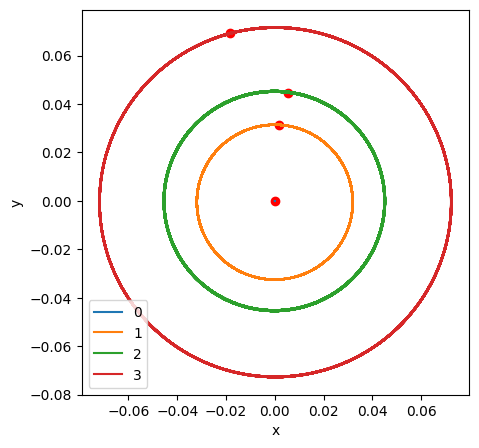

In [6]:
# Plot orbit
plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 10})
for i in range(len(radii)):
    plt.plot(positions_x[0,i],positions_y[0,i],c='r',ls='none',marker='o')
    plt.plot(positions_x[:,i],positions_y[:,i],label=i)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='lower left')

In [7]:
LC = LightCurve(radii_objects=radii,rad_unit="REarth",dist_unit="AU",xgrid=time)
objects = LC.compute_lightcurve(positions_x.copy(),positions_y.copy(),names)

slope=  290201.87088736356  intercept=  511908.3472010638
Errors= [0.03752153 4.66297078]


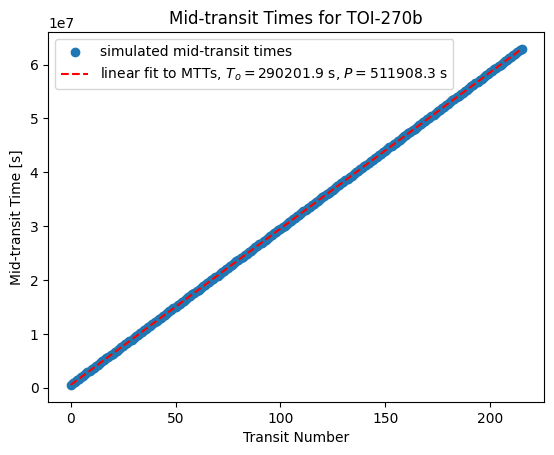

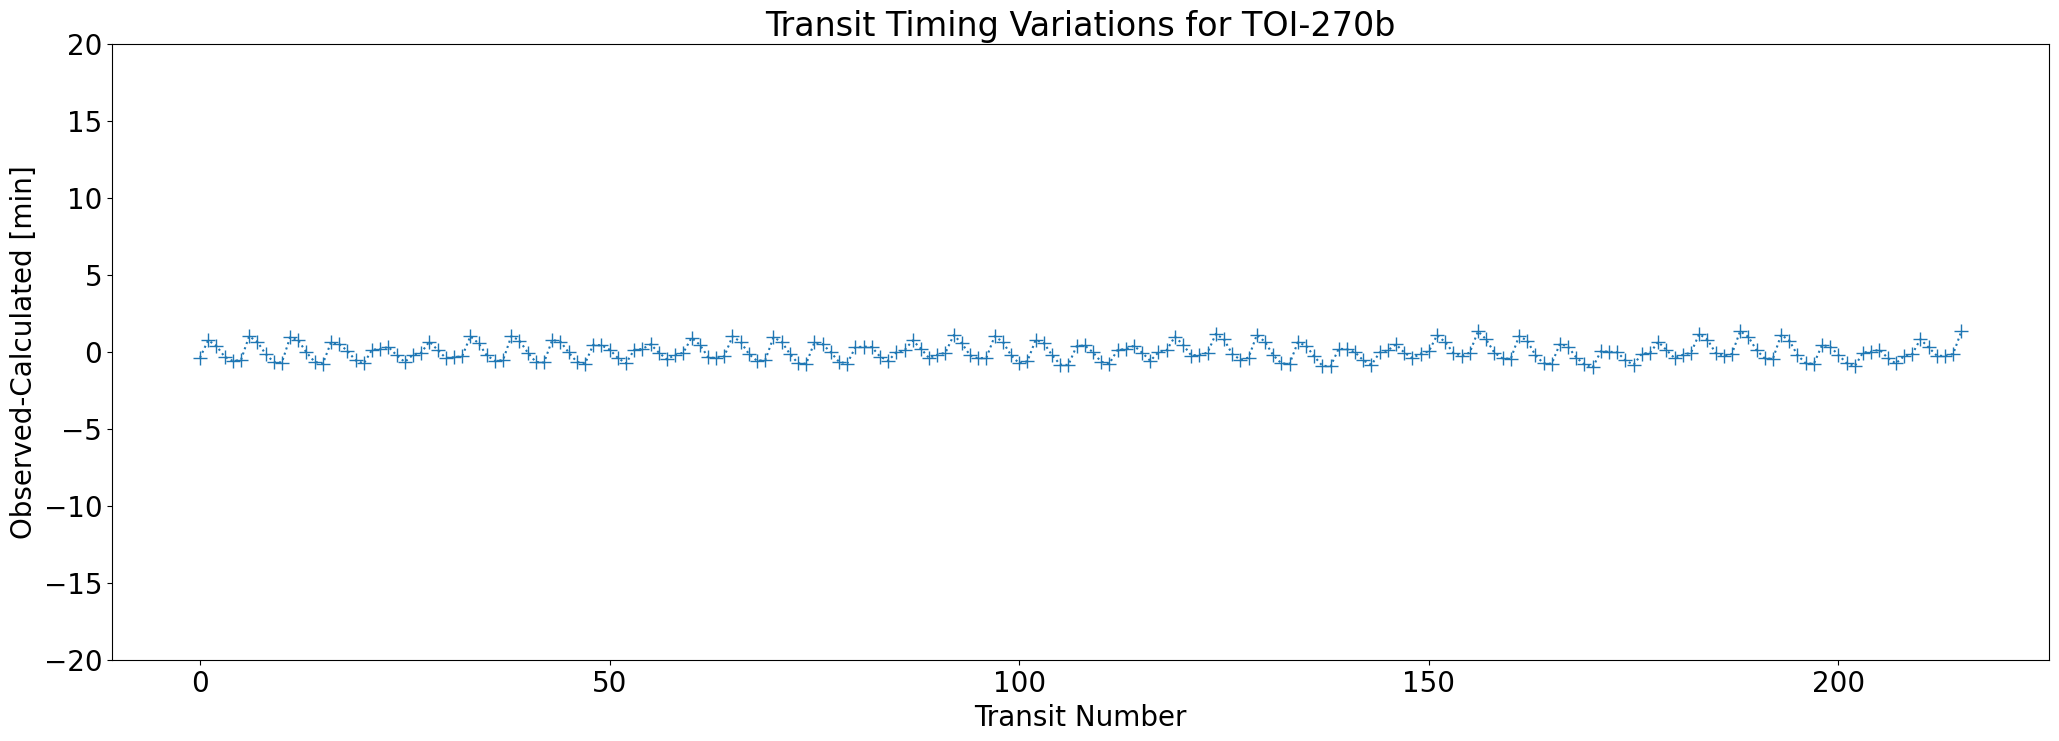

In [8]:
TTVinit = TransitTimingVariations(objects,large_dt,"TOI-270b")
MTTsb = TTVinit.compute_MTTs(plotfig=False,method="interpolate")
TTVsb = TTVinit.compute_TTVs(plotfig=True,plot_time_units="min",sizex=25,sizey=8,text_size=20)

slope=  489025.67085063085  intercept=  866894.2369238646
Errors= [ 0.76604634 56.27964864]


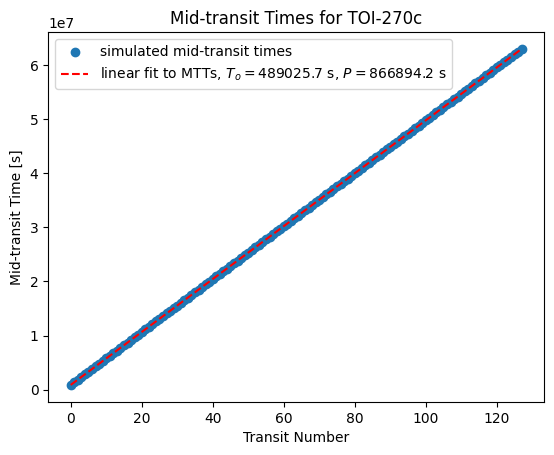

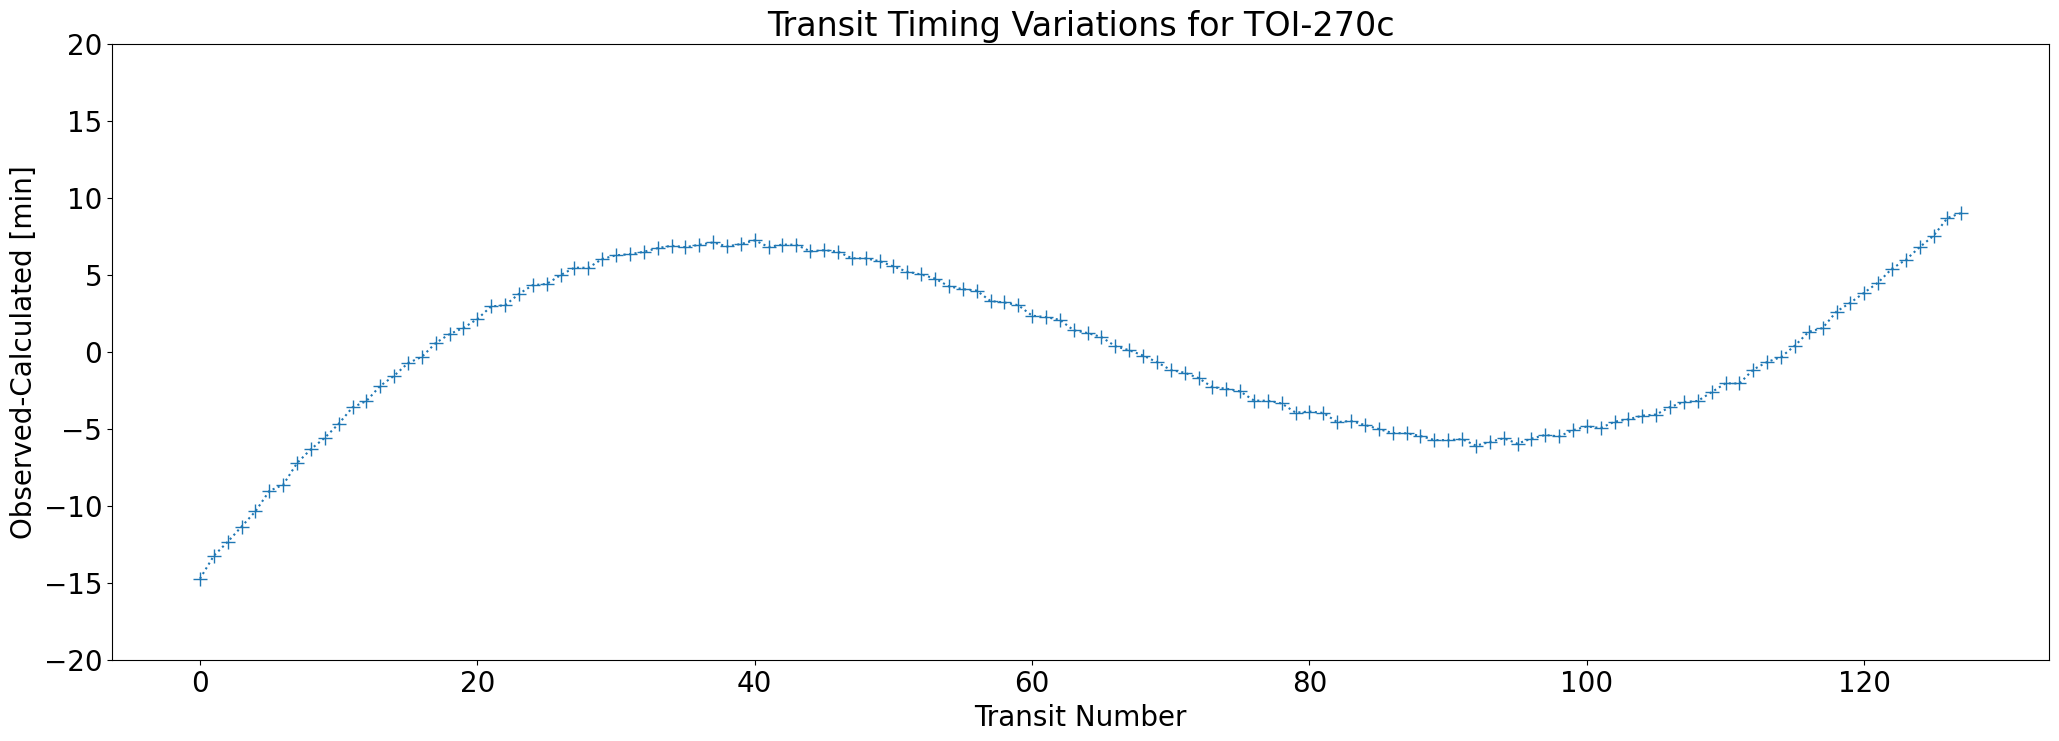

In [9]:
TTVinit = TransitTimingVariations(objects,large_dt,"TOI-270c")
MTTsc = TTVinit.compute_MTTs(plotfig=False,method="interpolate")
TTVsc = TTVinit.compute_TTVs(plotfig=True,plot_time_units="min",sizex=25,sizey=8,text_size=20)

slope=  983618.5119042824  intercept=  1680543.9087498388
Errors= [  3.67612496 132.11906336]


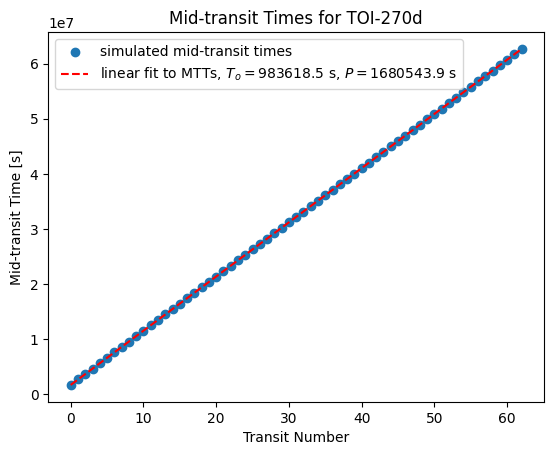

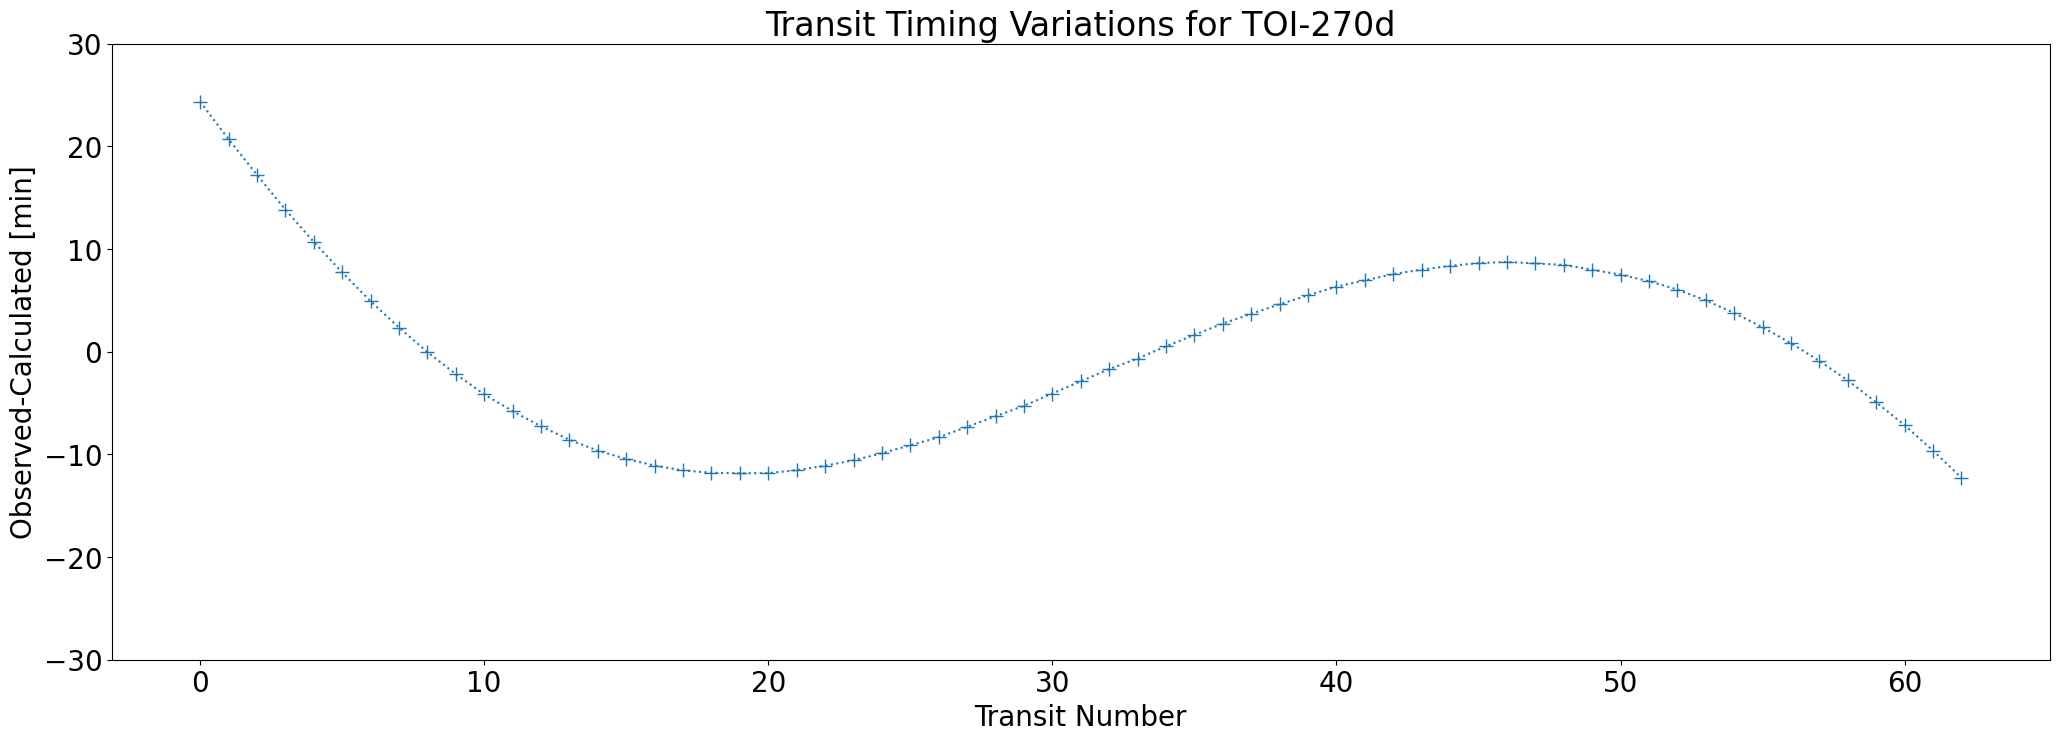

In [10]:
TTVinit = TransitTimingVariations(objects,large_dt,"TOI-270d")
MTTsd = TTVinit.compute_MTTs(plotfig=False,method="interpolate")
TTVsd = TTVinit.compute_TTVs(plotfig=True,plot_time_units="min",sizex=25,sizey=8,text_size=20,y_lim_min=30)

## Analysis

TOI-270b
A=-0.692 mins, omega=1.174 /epoch, phase=3.421
Error in A=0.044 mins, error in omega=0.003 /epoch, error in phase=0.125
TOI-270c
A=6.945 mins, omega=0.058 /epoch, phase=5.539
Error in A=0.056 mins, error in omega=0.001 /epoch, error in phase=0.026
TOI-270d
A=10.092 mins, omega=0.118 /epoch, phase=-22.754
Error in A=0.283 mins, error in omega=0.003 /epoch, error in phase=0.092


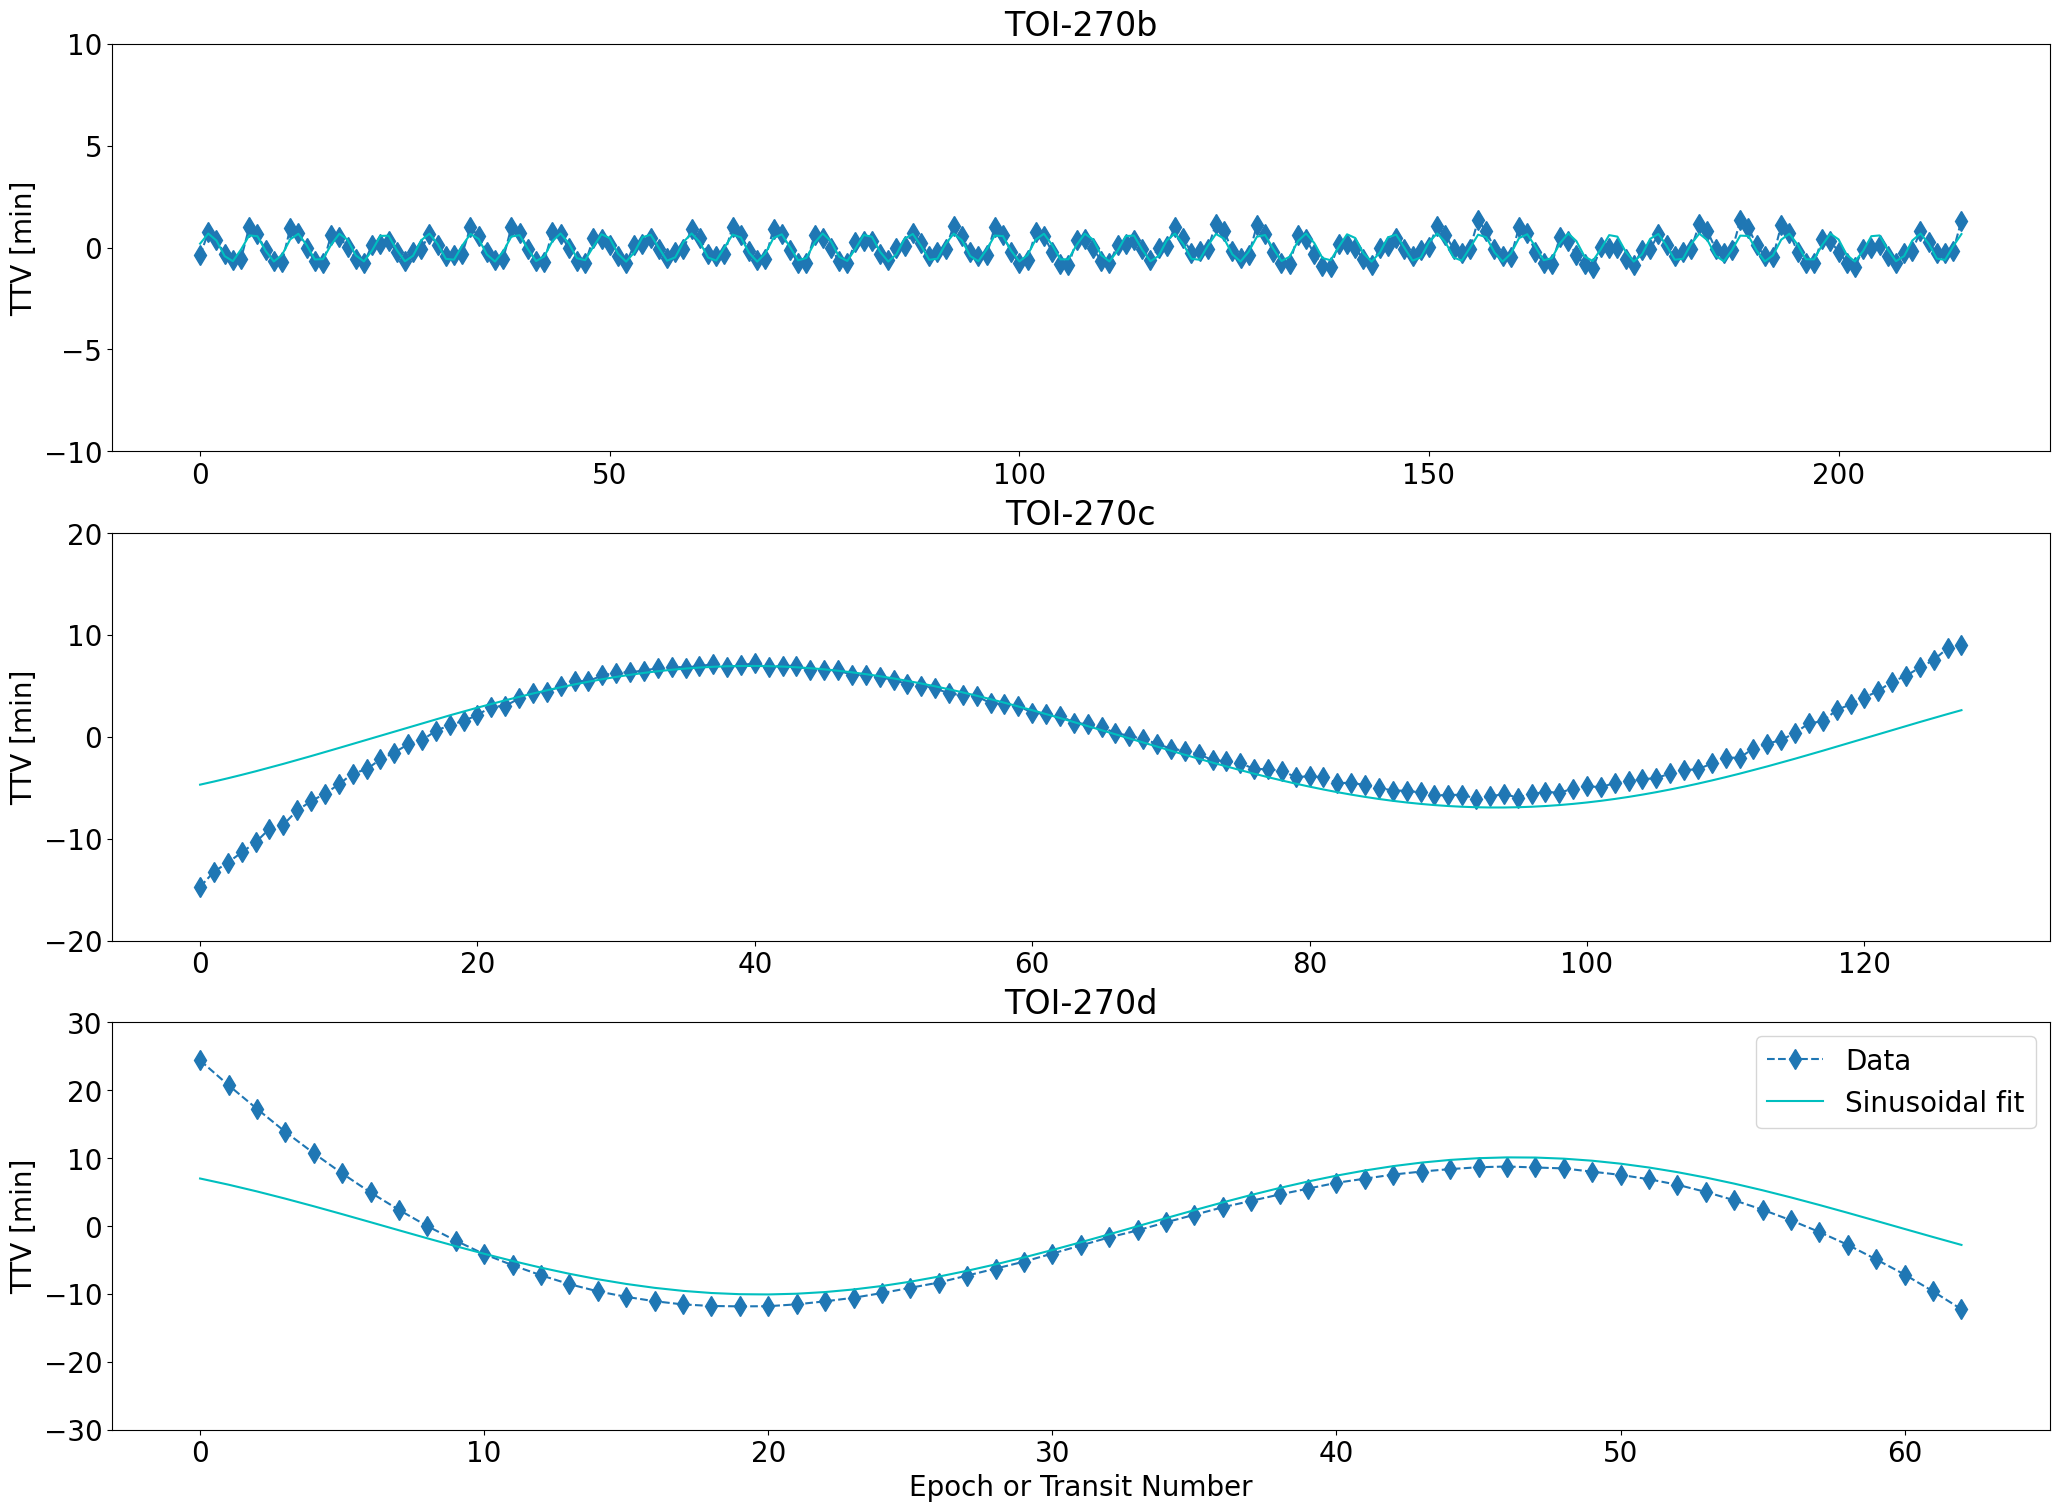

In [11]:
'''Fitting the TTVs to sinusoids to extract TTV periods'''
plt.rcParams.update({'font.size': 20})
fig = plt.subplots(3,1,figsize=(25,6*3))

def sin_func(x,A,om,phi):
    return A*np.sin(om*x+phi)

init_guesses = np.array([[5,2*np.pi/5,1],[10,2*np.pi/40,1],[15,2*np.pi/100,-20]])
y_limits = np.array([10,20,30])
all_results = np.zeros_like(init_guesses)
all_errors = np.zeros_like(init_guesses)
slice_vals = np.array([[0,70],[20,70],[10,55]]).astype(int) # use this for 2 years
# slice_vals = np.array([[0,70],[25,100],[0,110]]).astype(int) # use this slice for 3.5 years

for i, TTVs in enumerate([TTVsb,TTVsc,TTVsd]):
    print(names[i+1])
    s0 = slice_vals[i,0]
    s1 = slice_vals[i,1]
    popt, pcov = curve_fit(sin_func,range(s0,s1,1),TTVs[s0:s1]/60,p0=init_guesses[i])
    perr = np.sqrt(np.diag(pcov))
    model_rslt = sin_func(range(len(TTVs)),popt[0],popt[1],popt[2])
    all_results[i] = popt[0:3]
    all_errors[i] = perr[0:3]
    print('A=%.3f mins, omega=%.3f /epoch, phase=%.3f'%(popt[0],popt[1],popt[2]))
    print('Error in A=%.3f mins, error in omega=%.3f /epoch, error in phase=%.3f'%(perr[0],perr[1],perr[2]))

    plt.subplot(3,1,i+1)
    plt.plot(range(len(TTVs)),TTVs/60,ls='--',marker='d',ms=10,label='Data')
    plt.plot(model_rslt,label='Sinusoidal fit',c='c')
    plt.ylim((-y_limits[i],y_limits[i]))
    plt.title(names[i+1])
    plt.ylabel('TTV [min]')

plt.xlabel('Epoch or Transit Number')
plt.legend()
plt.savefig('TOI-270_results.pdf')
plt.savefig('TOI-270_results.png')
plt.show()

In [12]:
'''Estimating the super-period of TOI-270c and d TTVs'''
# print(all_results)
# print(all_errors)
# T(epoch) = 2pi/omega => T(years) = T(epoch) * P_days/days_per_year
periodc = 5.66051 # in days, this is the orbital period, not the TTV period which we are looking for here
periodd = 11.3819 # in days
superperiodc = 2*np.pi/all_results[1,1] * periodc / 365.25
cerr = 2*np.pi/all_results[1,1]**2 * all_errors[1,1] * periodc / 365.25 # error formula derived analytically
superperiodd = 2*np.pi/all_results[2,1] * periodd / 365.25
derr = 2*np.pi/all_results[2,1]**2 * all_errors[2,1] * periodd / 365.25
print('Planet c:',superperiodc,'+-',cerr,'years')
print('Planet d:',superperiodd,'+-',derr,'years')

Planet c: 1.6685375693578803 +- 0.014391845437777962 years
Planet d: 1.6566800130803299 +- 0.038876504319725606 years


In [13]:
'''Period of TOI-270b TTVs'''
periodb = 3.35992 # in days, orbital period
ttvperiodb = 2*np.pi/all_results[0,1] * periodc
print('Planet b TTV period, in epochs:',2*np.pi/all_results[0,1],'+-',2*np.pi/all_results[0,1]**2 * all_errors[0,1])
berr = 2*np.pi/all_results[0,1]**2 * all_errors[0,1] * periodb
print('Planet b TTV period, in days:',ttvperiodb,'+-',berr,'days')

Planet b TTV period, in epochs: 5.353694385921468 +- 0.014267514492481098
Planet b TTV period, in days: 30.30464060845233 +- 0.04793770729357709 days


In [14]:
'''Orbital period ratios'''
fit_periods = np.array([290202,489026,983619]) # in seconds, from the MTT linear fit (printed after compute_MTTs() calls)
print('Periods recovered from the fit:',fit_periods/(3600*24),'days')
c_to_b = fit_periods[1]/fit_periods[0]
d_to_c = fit_periods[2]/fit_periods[1]
print('The T_c/T_b ratio is:',c_to_b,'and was expected to be 5:3 or',5/3)
print('The T_d/T_c ratio is:',d_to_c,'and was expected to be 2:1 or',2)

Periods recovered from the fit: [ 3.35881944  5.66002315 11.38447917] days
The T_c/T_b ratio is: 1.6851227765487489 and was expected to be 5:3 or 1.6666666666666667
The T_d/T_c ratio is: 2.0113838528012824 and was expected to be 2:1 or 2
